In [1]:
from gensim import corpora, models
import pandas as pd
import os
from pprint import pprint
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# Functions

In [2]:
def draw_topics_distribution(topic_distrb, topic_num):
    ''' take topic distribution and the topic number 
    draws distribution 
    '''
    data = topic_distrb[topic_num]
    distrib = pd.DataFrame(data)
    fig, ax = plt.subplots(1,1,figsize =(10,5))
    g1 = sns.barplot(x = distrib[0], y = distrib[1].astype(float), palette = "mako")
    g1.set(title = 'distribution of words in topic number {}'.format(topic_num),\
         xlabel ='words', ylabel = 'probability of the word' )
    plt.xticks(rotation=90)
    plt.show()
    
    


In [3]:
def get_topic_distribution(lda_model):
    topics_distrib = {}
    for t in lda_model.show_topics(21):
        topics_distrib[t[0]] =[(a.split('*')[1][1:-1],float(a.split("*")[0])) for a in t[1].split(' + ')]
    return topics_distrib

In [4]:
def get_now_str():
    return datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Getting training data

In [8]:
folder = '../CRAFT/data'

In [10]:
train_data = pd.read_csv(os.path.join(folder,'data_train.csv'))
#annotations = pd.read_csv(os.path.join(folder,"annotations_21_raw.csv"),index_col = 0 )
#topics = pd.read_csv(os.path.join(folder,'topics_per_document.csv'))

In [7]:
# train_topics = topics.merge(train_data['PMID'])
# train_topics = train_topics.drop_duplicates(subset='PMID').reset_index(drop=True)

reading data in a proper format 

In [11]:
columns = ['tokenized_sentences', 'tokenized_words', 'tokenized_words_lemmatize']
for col in columns:
    train_data[col] = train_data[col].apply(eval)

# columns = ['Topics', 'Unique_topics']
# for col in columns:
#     train_topics[col] = train_topics[col].apply(eval)

#  LDA training

In [12]:
texts = train_data.groupby('PMID')['tokenized_words_lemmatize'].agg(lambda x: x.iloc[0]+x.iloc[1])

In [13]:
dictionary = corpora.Dictionary(texts)

In [14]:
corpus = [dictionary.doc2bow(text) for text in texts]

In [15]:
# number of topics - number of semantics
num_topics = 10
lda_model = models.LdaMulticore(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=num_topics,
                                       passes = 20)
doc_lda = lda_model[corpus]

# Visualization

## words for each topics

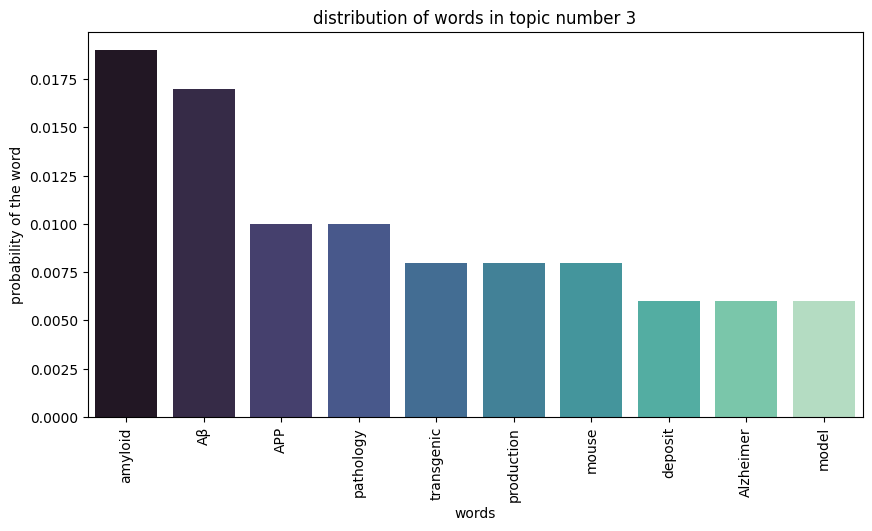

In [25]:
topic_distribution = get_topic_distribution(lda_model)
draw_topics_distribution(topic_distribution,3)

Get the dominat topic from LDA and dominant Semantic type 

In [14]:
#train_topics['Dominant_topic'] = train_topics['Topics'].apply(lambda x: sorted({k:v/len(x) for k,v in dict(Counter(x)).items()}.items(), key=lambda item: item[1], reverse=True)[0][0] )

In [26]:
topic_per_pmid = train_data[['PMID']].drop_duplicates(subset=['PMID']).reset_index(drop=True)
topic_per_pmid['LDA_dominant_topic'] = pd.Series(doc_lda).apply(lambda x: x[0][0])

## Semantic types for topic

In [29]:
from wordcloud import WordCloud

In [17]:
results = topic_per_pmid[['PMID','LDA_dominant_topic'] ].merge(train_topics[['PMID','Dominant_topic']], on = 'PMID')

In [18]:
semantics_per_topic = results[['LDA_dominant_topic','Dominant_topic']].groupby('LDA_dominant_topic').apply(lambda r: ' '.join(list(r['Dominant_topic'])))

## Most popular semantics per topic from LDA

NameError: name 'semantics_per_topic' is not defined

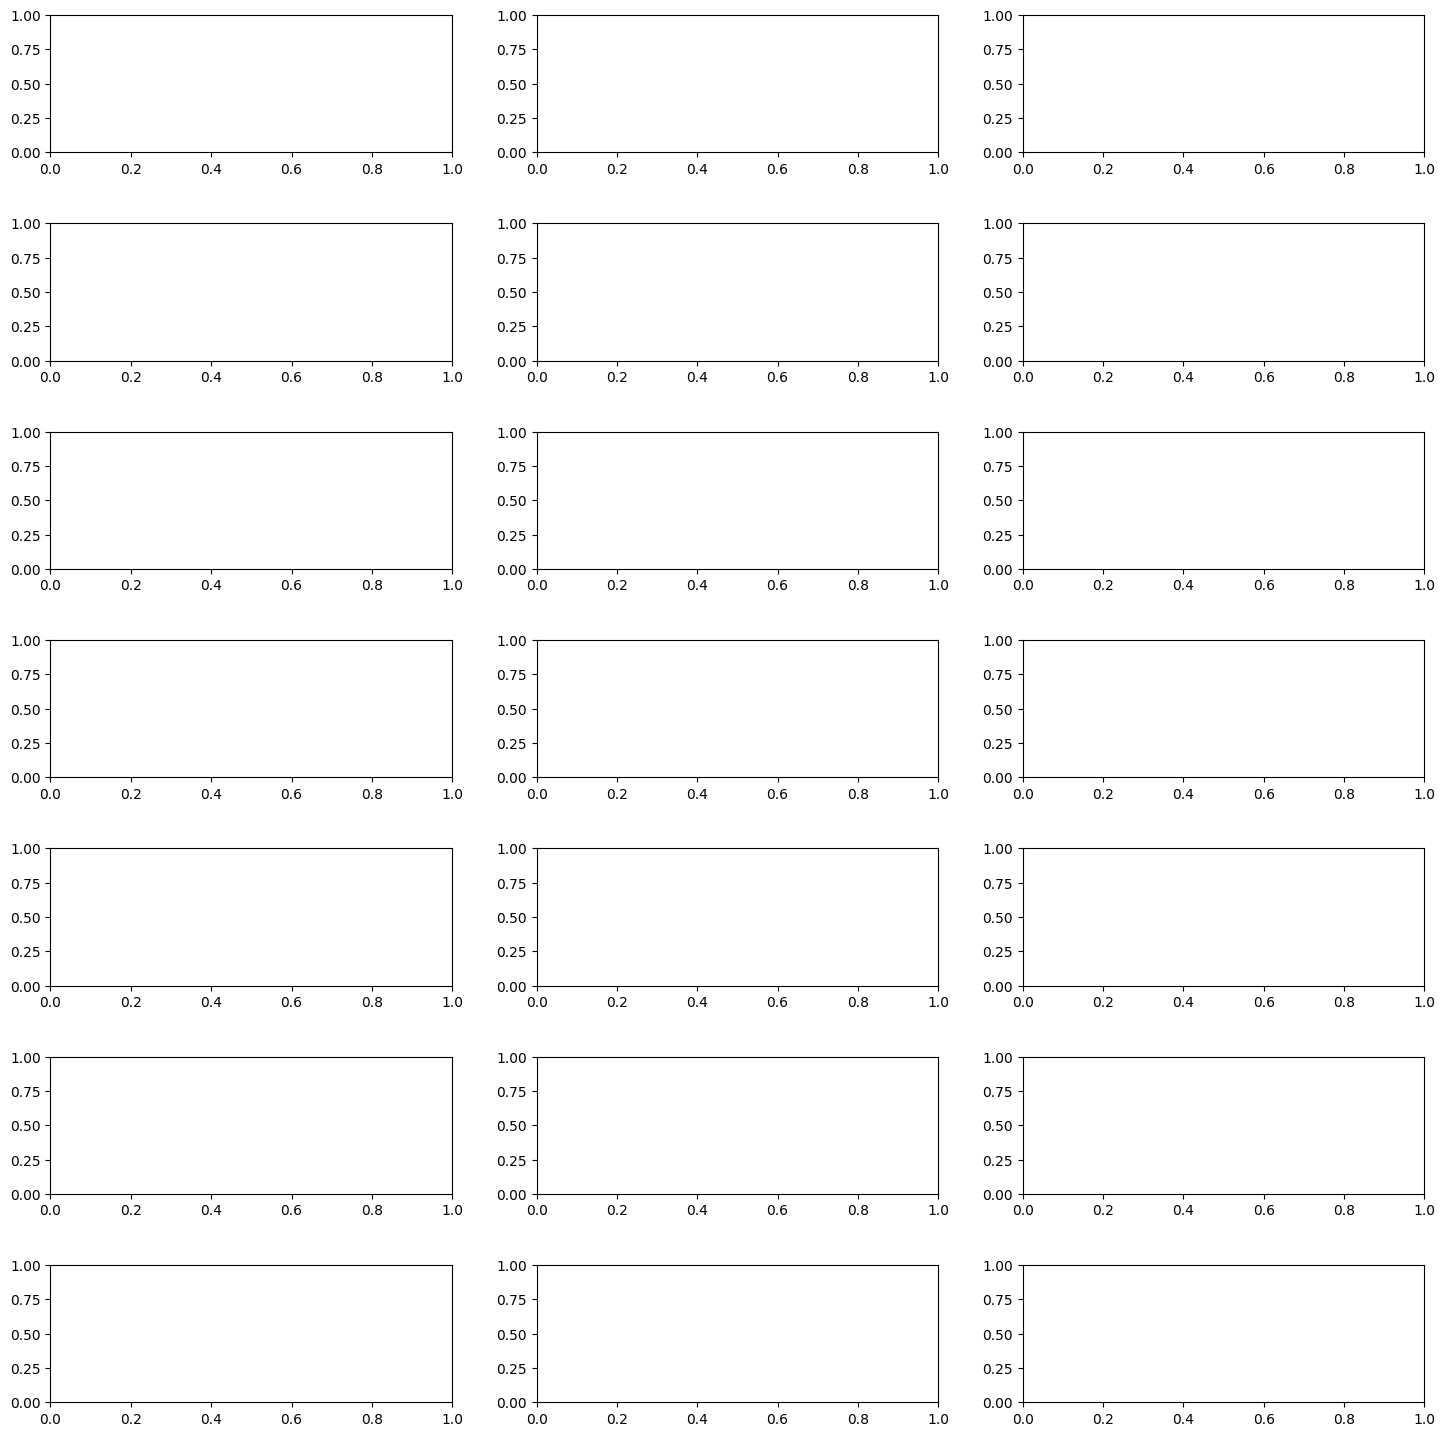

In [30]:
fig, ax = plt.subplots(7,3,figsize =(15,15))
fig.tight_layout(pad=3.0)
wordcloud = WordCloud(background_color="white",max_words  = 5)
for i in range(21):
    topic_vis = wordcloud.generate(semantics_per_topic[i])
    ax[int(i/3),int(i%3)].imshow(wordcloud, interpolation='bilinear')
    ax[int(i/3),int(i%3)].axis("off")
    ax[int(i/3),int(i%3)].set_title(f'Topic number {i}')
plt.show()


# Test data

In [16]:
test_data = pd.read_csv(os.path.join(folder,'data_test.csv'))
columns = ['tokenized_sentences', 'tokenized_words', 'tokenized_words_processed']
for col in columns:
    test_data[col] = test_data[col].apply(eval)


In [17]:
test_texts = test_data.groupby('PMID')['tokenized_words_processed'].agg(lambda x: x.iloc[0]+x.iloc[1])

In [18]:
test_corpus = [dictionary.doc2bow(text) for text in test_texts]

In [19]:
doc_lda_test = lda_model[test_corpus]

# Saving data

In [39]:
results_folder = '../CRAFT/results/lda'

saving topic distribution

In [42]:
topics_results = pd.DataFrame.from_records([topic_distribution]).T.reset_index().rename(columns = {'index':'topic_number',0:'topic_keywords'})
topics_results.to_csv(os.path.join(results_folder, f'topic_distribution_{get_now_str()}.csv'))

In [43]:
docs_train= []
for doc in doc_lda:
    docs_train.append({
        'topic_number':doc[0][0],
        'topic_probs': float(doc[0][1]),
        'topic_keywords': topics_results.iloc[doc[0][0]]['topic_keywords']

    })
docs_train = pd.DataFrame.from_records(docs_train)

In [44]:
docs_train

,topic_number,topic_probs,topic_keywords
0,1,0.985710,"[(mouse, 0.016), (gene, 0.011), (cell, 0.01), ..."
1,5,0.993021,"[(mouse, 0.027), (cell, 0.024), (gene, 0.015),..."
2,9,0.993791,"[(protein, 0.016), (gene, 0.015), (mouse, 0.01..."
3,1,0.994914,"[(mouse, 0.016), (gene, 0.011), (cell, 0.01), ..."
4,2,0.994827,"[(mouse, 0.015), (gene, 0.014), (mutant, 0.012..."
...,...,...,...
72,1,0.991586,"[(mouse, 0.016), (gene, 0.011), (cell, 0.01), ..."
73,7,0.994303,"[(cell, 0.015), (mouse, 0.011), (heterochromat..."
74,4,0.991890,"[(mouse, 0.02), (expression, 0.02), (gene, 0.0..."
75,1,0.991506,"[(mouse, 0.016), (gene, 0.011), (cell, 0.01), ..."


In [45]:
docs_test = []
for doc in doc_lda_test:
    docs_test.append({
        'topic_number':doc[0][0],
        'topic_probs':float(doc[0][1]),
        'topic_keywords': topics_results.iloc[doc[0][0]]['topic_keywords']

    })
docs_test = pd.DataFrame.from_records(docs_test)

In [46]:
train_results = train_data[['PMID']].drop_duplicates().reset_index(drop=True).join(docs_train)
train_results.to_csv(os.path.join(results_folder, f'LDA_train_{get_now_str()}.csv'))

In [47]:
test_results = test_data[['PMID']].drop_duplicates().reset_index(drop=True).join(docs_test)
test_results.to_csv(os.path.join(results_folder, f'LDA_test_{get_now_str()}.csv'))

# saving model

In [48]:
model_folder  = '../models'

In [49]:
lda_model.save(os.path.join(model_folder,f"lda_{get_now_str()}"))